In [1]:
# This line imports the NumPy package
import numpy as np

In [2]:
# This line imports the Pnadas package
import pandas as pd

In [3]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure.
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction

[scikit-learn](http://scikit-learn.org) is a Python package designed to give access to well-known machine learning algorithms within Python code, through a clean, well-thought-out API. It has been built by hundreds of contributors from around the world, and is used across industry and academia.

scikit-learn is built upon Python's [NumPy](http://www.numpy.org/) (Numerical Python) and [SciPy](http://www.scipy.org/) (Scientific Python) libraries, which enable efficient in-core numerical and scientific computation within Python. As such, scikit-learn is not specifically designed for extremely large datasets, though there is some work in this area.

# Machine Learning 101

## Data Representation

Most machine learning algorithms implemented in scikit-learn expect a **two-dimensional array or matrix** `X`, usually represented as a NumPy ndarray. The expected shape of `X` is `(n_samples, n_features)`.

* `n_samples`: The number of samples, where each sample is an item to process (e.g., classify). A sample can be a document, a picture, a sound, a video, a row in database or CSV file, or whatever you can describe with a fixed set of quantitative traits.
* `n_features`:	The number of features or distinct traits that can be used to describe each item in a quantitative manner. Features are generally real-valued, but may be boolean or discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional (e.g. millions of features) with most of them being zeros for a given sample. In this case we may use `scipy.sparse` matrices instead of NumPy arrays so as to make the data fit in memory.

The *supervised* machine learning algorithms implemented in scikit-learn also expect a **one-dimensional array** `y` with shape `(n_samples,)`. This array associated a target class to every sample in the input `X`.

![data-layout.png](images/data-layout.png)

As an example, we will explore the Iris dataset. The machine learning community often uses a simple flowers database where each row in the database (or CSV file) is a set of measurements of an individual iris flower. Each sample in this dataset is described by 4 features and can belong to one of three target classes:

**Features in the Iris dataset:**
 	
* sepal length in cm
* sepal width in cm
* petal length in cm
* petal width in cm

**Target classes to predict:**
 	
* Iris Setosa
* Iris Versicolour
* Iris Virginica

Scikit-Learn embeds a copy of the Iris CSV file along with a helper function to load it into NumPy arrays:

In [8]:
from sklearn.datasets import load_iris
iris = load_iris()

The features of each sample flower are stored in the `data` attribute of the dataset:

In [5]:
n_samples, n_features = iris.data.shape

print(n_samples)
print(n_features)
print(iris.data[0])

150
4
[5.1 3.5 1.4 0.2]


The information about the class of each sample is stored in the `target` attribute of the dataset:

In [6]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


This data is four dimensional, but we can visualize two of the dimensions at a time using a simple scatter-plot:

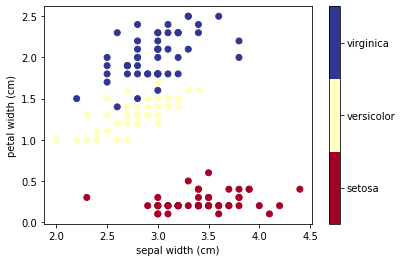

In [13]:
x_index = 1
y_index = 3

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target, cmap=plt.cm.get_cmap('RdYlBu', 3))
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.clim(-0.5, 2.5)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])

plt.show()

The previous example deals with features that are readily available in a structured dataset with rows and columns of numerical or categorical values.

However, most of the produced data is not readily available in a structured representation such as SQL, CSV, XML, JSON or RDF.

Here is an overview of strategies to turn unstructed data items into arrays of numerical features.

**Text documents**:	

* Count the frequency of each word or pair of consecutive words in each document. This approach is called Bag of Words.
* Note: we include other file formats such as HTML and PDF in this category: an ad-hoc preprocessing step is required to extract the plain text in UTF-8 encoding for instance.

**Images**:	

* Rescale the picture to a fixed size and take all the raw pixels values (with or without luminosity normalization)
* Take some transformation of the signal (gradients in each pixel, wavelets transforms...)
* Compute the Euclidean, Manhattan or cosine similarities of the sample to a set reference prototype images aranged in a code book. The code book may have been previously extracted from the same dataset using an unsupervised learning algorithm on the raw pixel signal.
* Each feature value is the distance to one element of the code book.
* Perform local feature extraction: split the picture into small regions and perform feature extraction locally in each area.
* Then combine all the features of the individual areas into a single array.

**Sounds**:	

* Same strategy as for images within a 1D space instead of 2D


## Supervised Learning

![supervised machine learning overview](images/plot_ML_flow_chart_12.png)

A supervised learning algorithm makes the distinction between the raw observed data `X` with shape `(n_samples, n_features)` and some label given to the model while training by some teacher. In scikit-learn this array is often noted `y` and has generally the shape `(n_samples,)`.

After training, the fitted model does no longer expect the `y` as an input: it will try to predict the most likely labels `y_new` for new a set of samples `X_new`.

Depending on the nature of the target `y`, supervised learning can be given different names:

* If `y` has values in a fixed set of **categorical outcomes** (represented by integers) the task to predict `y` is called **classification**.
* If `y` has **floating point values** (e.g. to represent a price, a temperature, a size...), the task to predict `y` is called **regression**.

### Classification Example

K nearest neighbors (kNN) is one of the simplest learning strategies: given a new, unknown observation, look up in your reference database which ones have the closest features and assign the predominant class.

Let's try it out on our iris classification problem:

In [15]:
from sklearn import neighbors, datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X, y)

# What kind of iris has 3cm x 5cm sepal and 4cm x 2cm petal?
# call the "predict" method:
result = knn.predict([[3, 5, 4, 2],])

print(iris.target_names[result])

['versicolor']


### Regression Example

One of the simplest regression problems is fitting a line to data, which we saw above. Scikit-learn also contains more sophisticated regression algorithms.

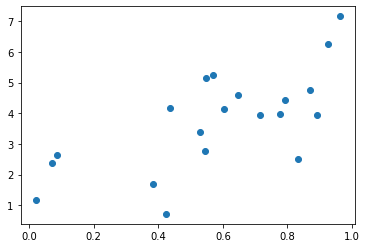

In [17]:
# Create some simple data
import numpy as np
np.random.seed(0)
X = np.random.random(size=(20, 1))
y = 3 * X.squeeze() + 2 + np.random.randn(20)

plt.plot(X.squeeze(), y, 'o')
plt.show()

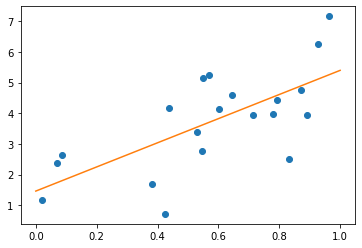

In [18]:
model = LinearRegression()
model.fit(X, y)

# Plot the data and the model prediction
X_fit = np.linspace(0, 1, 100)[:, np.newaxis]
y_fit = model.predict(X_fit)

plt.plot(X.squeeze(), y, 'o')
plt.plot(X_fit.squeeze(), y_fit)
plt.show()

Scikit-learn also has some more sophisticated models, which can respond to finer features in the data:

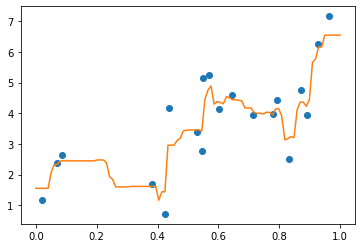

In [19]:
# Fit a Random Forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X, y)

# Plot the data and the model prediction
X_fit = np.linspace(0, 1, 100)[:, np.newaxis]
y_fit = model.predict(X_fit)

plt.plot(X.squeeze(), y, 'o')
plt.plot(X_fit.squeeze(), y_fit)
plt.show()

## Unsupervised Learning

![unsupervised machine learning overview](images/plot_ML_flow_chart_32.png)

Unsupervised learning addresses a different sort of problem. Here the data has no labels, and we are interested in finding similarities between the objects in question. 
An unsupervised learning algorithm only uses a single set of observations `X` with shape `(n_samples, n_features)` and does not use any kind of labels.

In a sense, you can think of unsupervised learning as a means of discovering labels from the data itself. Unsupervised learning comprises tasks such as *dimensionality reduction* and *clustering*. For example, in the Iris data discussed above, we can used unsupervised methods to determine combinations of the measurements which best display the structure of the data. 

Sometimes the two may even be combined: e.g. Unsupervised learning can be used to find useful features in heterogeneous data, and then these features can be used within a supervised framework.

### Dimensionality Reduction: PCA

Principle Component Analysis (PCA) is a dimension reduction technique that can find the combinations of variables that explain the most variance.

Consider the Iris dataset. It cannot be visualized in a single 2D plot, as it has 4 features. We are going to extract 2 combinations of sepal and petal dimensions to visualize it.

Reduced dataset shape: (150, 2)


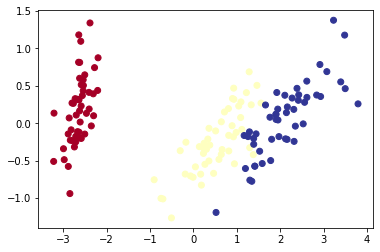

In [22]:
X, y = iris.data, iris.target

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='RdYlBu')
plt.show()

### Clustering: K-means

Clustering groups together observations that are homogeneous with respect to a given criterion, finding ''clusters'' in the data.

Note that these clusters will uncover relevent hidden structure of the data only if the criterion used highlights it.

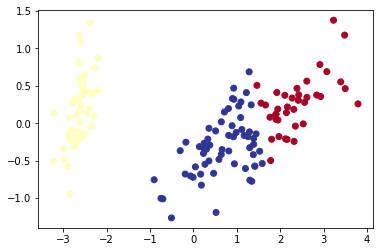

In [25]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3, random_state=0) # Fixing the RNG in kmeans
k_means.fit(X)
y_pred = k_means.predict(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='RdYlBu')
plt.show()

## Recap: Scikit-learn's estimator interface

Scikit-learn strives to have a uniform interface across all methods, and we have seen see examples of these above. Every algorithm is exposed in scikit-learn via an **estimator** object. Given a scikit-learn estimator object named model, the following methods are available:

* Available in **all estimators**:
    - `model.fit()`: fit training data. For supervised learning applications, this accepts two arguments: the data `X` and the labels `y` (e.g. `model.fit(X, y)`). For unsupervised learning applications, this accepts only a single argument, the data `X` (e.g. `model.fit(X)`).

* Available in **supervised estimators**:

    - `model.predict()`: given a trained model, predict the label of a new set of data. This method accepts one argument, the new data `X_new` (e.g. `model.predict(X_new)`), and returns the learned label for each object in the array.
    - `model.predict_proba()`: For classification problems, some estimators also provide this method, which returns the probability that a new observation has each categorical label. In this case, the label with the highest probability is returned by `model.predict()`.
    - `model.score()`: for classification or regression problems, most estimators implement a score method. Scores are between 0 and 1, with a larger score indicating a better fit.

* Available in **unsupervised estimators**:

    - `model.predict()`: predict labels in clustering algorithms.
    - `model.transform()`: given an unsupervised model, transform new data into the new basis. This also accepts one argument X_new, and returns the new representation of the data based on the unsupervised model.
    - `model.fit_transform()`: some estimators implement this method, which more efficiently performs a fit and a transform on the same input data.

## Validation

Consider the digits example we've been looking at previously. How might we check how well our model fits the data?

In [26]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

y_pred = knn.predict(X)

print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


It seems we have a perfect classifier! **What's wrong with this?**

We made the mistake of *testing our data on the same set of data that was used for training*. This is not generally a good idea. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.

A better way to test a model is to **use a hold-out set which doesn't participate in the training**, using scikit-learn's train/test split utility.

![Train-Test-Split-Diagram.jpg](images/Train-Test-Split-Diagram.jpg)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, X_test.shape

((1347, 64), (450, 64))

Now we train on the training data, and validate on the test data:

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))


440 / 450 correct


This gives us a more reliable estimate of how our model is doing.

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

In [29]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9777777777777777


## Cross Validation

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice:

In [30]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)

print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.9832962138084632
0.982202447163515


Here we've used 2-fold cross-validation. This is just one specialization of **$K$-fold cross-validation**, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set:

In [31]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

print(cv.mean())

0.9749627560521414


In standard $K$-fold cross-validation, we partition the data into $K$ subsets, called **folds**. Then, we iteratively train the algorithm on $k-1$ folds while using the remaining fold as the test set (called the “**holdout fold**”):

![Cross-Validation-Diagram.jpg](images/Cross-Validation-Diagram.jpg)

## Overfitting, Underfitting and Model Selection

The issues associated with validation and cross-validation are some of the most important aspects of the practice of machine learning. Selecting the optimal model for your data is vital, and is a piece of the problem that is not often appreciated by machine learning practitioners.

Of core importance is the following question: **if our estimator is underperforming, how should we move forward?**
How do we address this question?

* Use simpler or more complicated model?
* Add more features to each observed data point?
* Add more training samples?

The answer is often counter-intuitive. In particular, sometimes using a more complicated model will give worse results. Also, sometimes adding training data will not improve your results.

**Generalization** refers to how well the concepts learned by a machine learning model apply to *specific examples not seen by the model when it was learning*.
The goal of a good machine learning model is to *generalize well from the training data to any data* from the problem domain. This allows us to make predictions in the future on data the model has never seen.

There is a terminology used in machine learning when we talk about how well a machine learning model learns and generalizes to new data, namely *underfitting* and *overfitting*.
Underfitting and overfitting are the two biggest causes for poor performance of machine learning algorithms.

**Underfitting** refers to a model that can neither model the training data nor generalize to new data.
An underfit machine learning model is not a suitable model and will be obvious as it will have poor performance on the training data. Underfitting is often not discussed as it is easy to detect given a good performance metric. The remedy is to move on and try alternate machine learning algorithms.

**Overfitting** refers to a model that models the training data too well.
Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

To illustrate overfitting, we'll work with a simple linear regression problem.

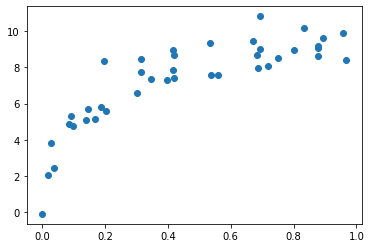

In [32]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

X, y = make_data(40, error=1)

plt.scatter(X.ravel(), y)
plt.show()

Now we want to perform a regression on this data, using the scikit-learn built-in linear regression function to compute a fit:

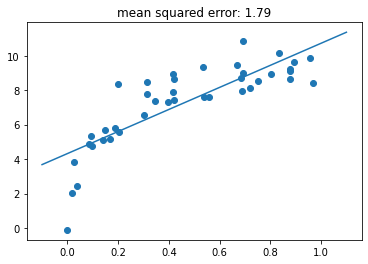

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)

X_test = np.linspace(-0.1, 1.1, 500).reshape(500,1)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.show()

We have fit a straight line to the data, but clearly this model is not a good choice: *this model under-fits the data.*

We try to improve this by creating a more complicated model. We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. 

Let's make a convenience routine to do this:

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Let see what happens with a 2-degrees and a 30-degrees polynomial regression:

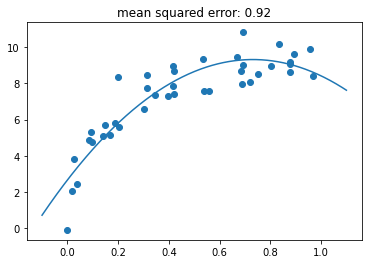

In [37]:
model = PolynomialRegression(2)
model.fit(X, y)

y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.show()

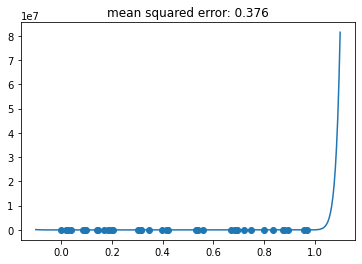

In [43]:
model = PolynomialRegression(30)
model.fit(X, y)

y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.show()

In the first case (2 degrees) we have a much better fit, while in the second case (30 degrees), this model is not a good choice again.

We can use cross-validation to get a better handle on how the model fit is working. Let's do this here, again using the `validation_curve` utility. To make things more clear, we'll use a slightly larger dataset.

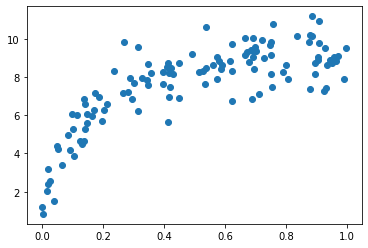

In [44]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);
plt.show()

In [45]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

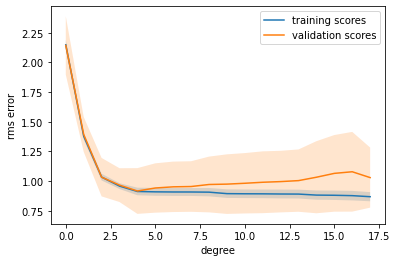

In [46]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend()
plt.show()

Notice the trend here, which is common for this type of plot.

* For a small model complexity, the training error and validation error are very similar. This indicates that the model is *under-fitting the data*: it doesn't have enough complexity to represent the data.
* As the model complexity grows, the training and validation scores diverge. This indicates that the model is *over-fitting the data*: it has so much flexibility, that it fits the noise rather than the underlying trend. 
* Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.


# Text Analytics

Now we will illustrate the main functionalities of scikit-learn when dealing with texts.
We will go through a typical text mining pipeline where our goal is to train a machine learning model that classifies texts scraped from company website into two classes:

* 0: Text from a non-software company website.
* 1: Text from a software company website.

## Loading text

We will now use the Pandas `pd.read_csv()` function to read in the textfiles containing our data. It is often conveninet to select a suitable method to load text, since very large files can be more efficiencly managed as Python's lists of NumPy's object ndarrays.

In [91]:
labelled_data = pd.read_csv("data/labelled_data.txt", sep="\t", encoding="utf-8", error_bad_lines=False)
labelled_data.head()

,ID,url,text,software
0,0,http://autzen-reimers.de,Seite: « 1 / 0 » « 1 / 0 »AUTZEN & REIMERSARCH...,0
1,1,https://ibos-goerlitz.de/,Das Ingenieurbüro IBOS GmbH wurde am 17.09.199...,0
2,2,https://kaizhong-vogt.de/,capanne.gittinger.de,0
3,3,https://baecker-holland.de/,Klicken Sie hier um zu unserem Kon­takt­for­mu...,0
4,4,https://www.vbhnr.de/privatkunden.html,Um Ihnen eine bessere Nutzung unserer Seite zu...,0


As we can see, our data is in a table format with 4 columns:

* **ID**: unique identifiers for each observation
* **url**: the website address from where text was downloaded
* **text**: the downloaded website text
* **software**: the label which tells us whether a website is from a software company ("1") or not ("0")

Using Pandas, we can perform some preliminary **data exploration** to check the characteristics of our data set.

In [92]:
n_samples, n_cols = labelled_data.shape
n_software = labelled_data["software"].sum()

print("number of documents:", n_samples)
print("number of columns:", n_cols)
print("number of 'software' documents:", n_software)
print("number of 'non-software' documents:", n_samples - n_software)

number of documents: 2000
number of columns: 4
number of 'software' documents: 284
number of 'non-software' documents: 1716


In [93]:
unlabelled_data = pd.read_csv("data/unlabelled_data.txt", sep="\t", encoding="utf-8", error_bad_lines=False)

n_samples, n_cols = unlabelled_data.shape
print("number of documents:", n_samples)
print("number of columns:", n_cols)

unlabelled_data.head()

number of documents: 937
number of columns: 3


,ID,url,text
0,0,http://wimatec-mattes.de,Dieses Motto begleitet uns täglich bei der Arb...
1,1,https://www.jacobi.net/,Reactivated carbons for water and vapour treat...
2,2,https://www.basf.com/de.html,Cookies helfen uns bei der Bereitstellung unse...
3,3,http://gjb.de,Diese Seite verwendet Frames. Frames werden vo...
4,4,https://www.roda-swiss.de/,| Transparenz und Ihre Privatsphäre sind uns w...


In [86]:
labelled_data["text"].apply(len).describe()

count      2000.000000
mean       2558.813500
std        5144.796468
min           1.000000
25%         703.000000
50%        1472.500000
75%        2788.500000
max      135504.000000
Name: text, dtype: float64

We can also easily plot the distribution of website text lengths by using pandas `plot()` method and passing the keywords for a histogram with 100 bins:

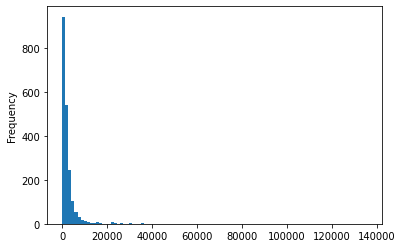

In [87]:
labelled_data["text"].apply(len).plot(kind="hist", bins=100)

We can also print some website text, just to get the feeling of the characteristics of the texts we must deal with:

In [88]:
print(labelled_data["text"][0], '\n')
print(labelled_data["text"][1], '\n')
print(labelled_data["text"][2], '\n')

Seite: « 1 / 0 » « 1 / 0 »AUTZEN & REIMERSARCHITEKTEN 

Das Ingenieurbüro IBOS GmbH wurde am 17.09.1990 in Görlitz gegründet. Unser Handlungsschwerpunkt liegt auf dem Gebiet der Siedlungswasserwirtschaft, des kommunalen Tiefbaues, der kommunalen Infrastruktur, des Wasserbaues, der Tragwerksplanung sowie der Bauleitungsplanung und Landschaftsplanung. In einem erfahrenen Team erstellen wir Planungen in allen Leistungsphasen der HOAI inklusive der Örtlichen Bauüberwachung und Sicherheits- und Gesundheitsschutzkoordination sowie Studien, Konzeptionen, Wirtschaftlichkeitsbetrachtungen und strategische Planungen. Als unabhängiges Ingenieurbüro sind wir frei von Interessen Dritter. Gern sind wir auch für Sie tätig – wir freuen uns über Ihre ! Wir suchen einen… Ihre Bewerbung richten Sie bitte an die unter aufgeführte Adresse, gern auch per E-Mail. Mitgeschickte Dateien nur im PDF-Format (keine ZIP-Datei). Am 20.09.2018 fand unsere im Gäste- und Tagungshaus KOMENSKÝ in Herrnhut statt. 100%iges

## Text preprocessing

The preliminary data exploration revealed some characteristics of the text, for example:

* We also may want to standardise all characters to lowercase, such that "Software" and "software" are recognized as the same words.
* There are quiet some websites with texts that are smaller than 500 characters and some even had only a single character in their "text" column.
* There are quite a lot of special characters (e.g. "€" or "§") and numbers in the text

Before feeding textual data to machine learning algorithms, it is often the case to preprocess the texts to remove unwanted documents, and to *normalize* the texts by removing clear noisy content.

We convert all characters to lowercase:

In [95]:
labelled_data['text'] = labelled_data["text"].apply(lambda text: str(text).lower())
unlabelled_data['text'] = unlabelled_data["text"].apply(lambda text: str(text).lower())
labelled_data['text'].head()

0    seite: « 1 / 0 » « 1 / 0 »autzen & reimersarch...
1    das ingenieurbüro ibos gmbh wurde am 17.09.199...
2                                 capanne.gittinger.de
3    klicken sie hier um zu unserem kon­takt­for­mu...
4    um ihnen eine bessere nutzung unserer seite zu...
Name: text, dtype: object

We remove the documents with less than 500 characters:

In [96]:
labelled_data = labelled_data[labelled_data["text"].apply(len) > 499]
labelled_data.shape

(1649, 4)

In [97]:
unlabelled_data = unlabelled_data[unlabelled_data["text"].apply(len) > 499]
unlabelled_data.shape

(772, 3)

We exclude special characters from the further analysis. We will import a python's "regular expression" operations and apply its `sub("FILTER", "REPLACE_STRING")` function to the text column of our labelled dataset. We submit the `sub()` function with a regular expression telling it to delete all characters in the text that are not part of this list of characters: "`abcdefghijklmnopqrstuvwxyzäöüß& `" (note the final whitespace char!).

In [100]:
import re

labelled_data["text"] = labelled_data["text"].apply(lambda text: re.sub("[^abcdefghijklmnopqrstuvwxyzäöüß& ']", "", str(text)))
unlabelled_data["text"] = unlabelled_data["text"].apply(lambda text: re.sub("[^abcdefghijklmnopqrstuvwxyzäöüß& ']", "", str(text)))
labelled_data.head()

,ID,url,text,software
1,1,https://ibos-goerlitz.de/,das ingenieurbüro ibos gmbh wurde am in görli...,0
3,3,https://baecker-holland.de/,klicken sie hier um zu unserem kontaktformular...,0
4,4,https://www.vbhnr.de/privatkunden.html,um ihnen eine bessere nutzung unserer seite zu...,0
5,5,https://www.whg-ebw.de/,informieren sie sich über die wohngebiete der ...,0
6,6,https://www.wittich.de/,amts und mitteilungsblätter reisemagazine maga...,0


## Text vectorization

The machine learning algorithms we will use require us to give numerical data to them. Raw text data as an input will not work! This means that we have to transfer our texts to some kind of numerical representation without loosing too much information. Transferring a text from a sequence of characters to a vector of numbers is called **text vectorization**.

![text_vectorization.png](images/text_vectorization.png)

There are many different ways to vectorize texts, from fancy techniques like [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) and topic models like [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) to simple [bag-of-words models](https://en.wikipedia.org/wiki/Bag-of-words_model).

The most intuitive way to turn the text content into numerical feature vectors is the **bags of words representation**:

* assign a **fixed integer id** to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

* for each document $d_i$, count the **number of occurrences** of each word $w$ and store it in $X[i, j]$ as the value of feature $w_j$ where $j$ is the index of word $w$ in the dictionary.

The bags of words representation implies that `n_features` is the number of distinct words in the corpus: this number is typically larger that 100,000.

If `n_samples` is 10,000, storing `X` as a NumPy array of type `float32` would require $10,000 x 100,000 x 4$ bytes = 4 GB in RAM which is barely manageable on today’s computers.

Fortunately, most values in `X` will be zeros since for a given document less than a couple thousands of distinct words will be used. For this reason we say that bags of words are typically *high-dimensional sparse datasets*. We can save a lot of memory by *only storing the non-zero parts of the feature vectors in memory*.
The `scipy.sparse` matrices are data structures that do exactly this, and scikit-learn has built-in support for these structures.

scikit-learn offers a provides basic tools to process text using the bag of words representation. To build such a representation we will proceed as follows:

* *tokenize* strings and *give an integer id* for each possible token, for instance by using whitespaces and punctuation as token separators.
* *count* the occurrences of tokens in each document.
* *normalize* and weighting with diminishing importance tokens that occur in the majority of samples / documents.

![tfidf_vectorization.png](images/tfidf_vectorization.png)

This approach is called [**TFIDF**](http://en.wikipedia.org/wiki/Tf–idf):

* **term frequency** (TF): counts the number of times a term $t$ (word) appears in a document $d$ adjusted by the length of the document (number of all words $t'$ in document $d$).
* **inverse document frequency** (IDF): counts the number of documents $n_t$ an individual term $t$ appears over all documents $N$.
* **term frequency-inverse document frequency** (TFIDF): weights down common words like "the" and gives more weight to rare words like "software".

To perform this vectorization, scikit-learn provides the `TfidfVectorizer` class:

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer().fit(labelled_data['text'])
print(tfidf_vect.transform(['dies ist ein test','dast ist nacth']))

  (0, 64619)	0.7674788380733668
  (0, 34005)	0.22768716559203767
  (0, 16620)	0.2383998438323033
  (0, 14515)	0.5498184265691286
  (1, 34005)	1.0


The output you see is a so-called *sparse matrix*. In a sparse matrix, only non-zero elements are memorized and mapped using indexes. This actually saves A LOT of memory. In the example above, there are only five non-zero elements in the matrix and their coordinates/indexes are given in the left parantheses. The elements on the right hand side give you the corresponding count value for the word mapped by the coordinates.

The `fit()` and `transform()` methods can be invoked sequentially or with the `fit_transform()` method:

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(labelled_data['text'])

Let's have a look at the vocabulary the vectorizer learned from our data. We call the `vocabulary_` property on the trained vectorizer to retrieve the full vocabulary and the use a little loop to print the first items in the vocabulary:

In [124]:
vocabulary = tfidf_vect.vocabulary_

#little loop to print the first items in the vocabulary
for count, item in enumerate(iter(vocabulary.items())):
    print(item)
    if count >= 10:
        break
        
print('The vocabulary contains', len(vocabulary), 'terms in total')

('das', 13209)
('ingenieurbüro', 32913)
('ibos', 31714)
('gmbh', 27194)
('wurde', 74328)
('am', 1890)
('in', 32182)
('görlitz', 28454)
('gegründet', 24982)
('unser', 67469)
('handlungsschwerpunkt', 28901)
The vocabulary contains 76713 terms in total


Those are quiet a lot of words. It may be a good idea to shrink down our vocabulary a bit, especially because this will reduce both memory consumption and required computational power.

A common approach to do so is to apply so-called *popularity-based filering*. Hereby, we exclude very common and/or extremly uncommon words from our vocabulary. This can be achieved by passing the corresponding parameters to the vectorizer during training.

Let's overwrite our vectorizer and create a new one which includes only the words appearing in at lead 1% of the documents:

In [125]:
vectorizer = TfidfVectorizer(min_df=0.01)
trained_vectorizer = vectorizer.fit(labelled_data["text"])
vocabulary = trained_vectorizer.vocabulary_
print('The vocabulary contains', len(vocabulary), 'terms in total')

The vocabulary contains 2628 terms in total


## Train and test splitting

We first randmly shuffle the samples in the DataFrame, then we extract the features and the labels.

In [126]:
# The sample method returns a random sample without replacement of items in the DataFrame
labelled_data = labelled_data.sample(frac=1.0, random_state=12)

features = trained_vectorizer.transform(labelled_data["text"])
labels = labelled_data["software"]

Now we split the features and labels into a train and test sets. The train set will contain the 75% of the whole dataset, while the test set the remaining 25%.

In [132]:
from sklearn.model_selection import train_test_split

features_trainset, features_testset, labels_trainset, labels_testset = train_test_split(features, labels, train_size=0.75)

print(features_trainset.shape)
print(features_testset.shape)

(1236, 2628)
(413, 2628)


## Training a Logistic Regression Classifier

We train a logistic regression classifier, a pretty popular model for binary outcome variables. We pass it the parameter `class_weight="balanced"` because we have a pretty unbalanced dataset (one class in way more frequent than the other). The "`balanced`" parameter will make sure that the model will pay more attention to the infrequent class (in our case the software = 1 class).

In [136]:
from sklearn.linear_model import LogisticRegression

logit_classifier = LogisticRegression(class_weight="balanced")
trained_logit_classifier = logit_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_logit_classifier.predict(features_testset)

Let's quantify the classifier's prediction performance by generating a scikit-learn **classification report**. The report contains several measures that allow us to evaluate the performance of our trained model in the test set:
* **precision**: the fraction of observations that were predicted to have label $\hat{y} = 1$ and that actually have the true label $y = 1$.
* **recall**: the fraction of observations that have the true label $y = 1$ and that were predicted to have $\hat{y} = 1$.
* **f1-score**: a composite measure that combines both precision and recall.
* **support**: simply the number of observations with this true label in the test set.

![classification_report.png](images/classification_report.png)

In [135]:
from sklearn.metrics import classification_report

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       343
           1       0.61      0.74      0.67        70

    accuracy                           0.88       413
   macro avg       0.78      0.82      0.80       413
weighted avg       0.89      0.88      0.88       413



We could summarize the report as follows:

* 95% of the observations that were labeled "0" by the classifier actually have the true label "0". For label "1" this value is only 69%
* 92% of the observations that have the true label "0" were also predicted to have have the label "0" by the classifier. For label "1" this value is only 78%.


## Training a Naive Bayes Classifier

In [138]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
trained_nb_classifier = nb_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_nb_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       343
           1       0.80      0.06      0.11        70

    accuracy                           0.84       413
   macro avg       0.82      0.53      0.51       413
weighted avg       0.83      0.84      0.77       413



## Training a Linear SVM Classifier

In [142]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel="linear", C=1000)
trained_svm_classifier = svm_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_svm_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       343
           1       0.68      0.57      0.62        70

    accuracy                           0.88       413
   macro avg       0.80      0.76      0.77       413
weighted avg       0.88      0.88      0.88       413



## Training a KNN Classifier

In [152]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(7)
trained_knn_classifier = knn_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_knn_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       343
           1       0.71      0.46      0.56        70

    accuracy                           0.88       413
   macro avg       0.80      0.71      0.74       413
weighted avg       0.87      0.88      0.87       413



## Training a decision tree classifier

In [155]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=7)
trained_dt_classifier = dt_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_dt_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       343
           1       0.69      0.53      0.60        70

    accuracy                           0.88       413
   macro avg       0.80      0.74      0.76       413
weighted avg       0.87      0.88      0.87       413



## Training a MLP Classifier

In [160]:
from sklearn.neural_network import MLPClassifier

mlp_classifier =  MLPClassifier(hidden_layer_sizes=(100,), alpha=0.5, max_iter=1000)
trained_mlp_classifier = mlp_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_mlp_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       343
           1       0.84      0.39      0.53        70

    accuracy                           0.88       413
   macro avg       0.87      0.69      0.73       413
weighted avg       0.88      0.88      0.87       413

